In [46]:
#Import packages and define helper functions and objects
import datetime
import time
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from operator import itemgetter
from itertools import groupby
import numpy as np
from imblearn.over_sampling import SMOTE
import math
from sklearn.metrics import roc_curve, roc_auc_score  

#Converts time string to float value
def string_to_timestamp(date_string):
    time_stamp = time.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    return time.mktime(time_stamp)

#Helper objects for encoding the categorical data
(issuercountry_set, txvariantcode_set, currencycode_set, shoppercountry_set, interaction_set,
verification_set, accountcode_set, mail_id_set, ip_id_set, card_id_set) = [set() for _ in range(10)]
(issuercountry_dict, txvariantcode_dict, currencycode_dict, shoppercountry_dict, interaction_dict,
verification_dict, accountcode_dict, mail_id_dict, ip_id_dict, card_id_dict) = [{} for _ in range(10)]
sm = SMOTE(random_state=42)


In [2]:
#Reads the data from the given csv
def get_raw_data() : 
    ah = open('data_for_student_case.csv', 'r')
    data = []
    ah.readline()#skip first line
    for line_ah in ah:
        if line_ah.strip().split(',')[9]=='Refused':# remove the row with 'refused' label, since it's uncertain about fraud
            continue
        if 'na' in str(line_ah.strip().split(',')[14]).lower() or 'na' in str(line_ah.strip().split(',')[4].lower()):
            continue
        bookingdate = string_to_timestamp(line_ah.strip().split(',')[1])# date reported flaud
        issuercountry = line_ah.strip().split(',')[2]#country code
        issuercountry_set.add(issuercountry)
        txvariantcode = line_ah.strip().split(',')[3]#type of card: visa/master
        txvariantcode_set.add(txvariantcode)
        issuer_id = float(line_ah.strip().split(',')[4])#bin card issuer identifier
        amount = float(line_ah.strip().split(',')[5])#transaction amount in minor units
        currencycode = line_ah.strip().split(',')[6]
        currencycode_set.add(currencycode)
        shoppercountry = line_ah.strip().split(',')[7]#country code
        shoppercountry_set.add(shoppercountry)
        interaction = line_ah.strip().split(',')[8]#online transaction or subscription
        interaction_set.add(interaction)
        if line_ah.strip().split(',')[9] == 'Chargeback':
            label = 1#label fraud
        else:
            label = 0#label save
        verification = line_ah.strip().split(',')[10]#shopper provide CVC code or not
        verification_set.add(verification)
        cvcresponse = int(line_ah.strip().split(',')[11])#0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
        if cvcresponse > 2:
            cvcresponse = 3
        year_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').year
        month_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').month
        day_info = datetime.datetime.strptime(line_ah.strip().split(',')[12],'%Y-%m-%d %H:%M:%S').day
        creationdate = str(year_info)+'-'+str(month_info)+'-'+str(day_info)#Date of transaction 
        creationdate_stamp = string_to_timestamp(line_ah.strip().split(',')[12])#Date of transaction-time stamp
        accountcode = line_ah.strip().split(',')[13]#merchant’s webshop
        accountcode_set.add(accountcode)
        mail_id = int(float(line_ah.strip().split(',')[14].replace('email','')))#mail
        mail_id_set.add(mail_id)
        ip_id = int(float(line_ah.strip().split(',')[15].replace('ip','')))#ip
        ip_id_set.add(ip_id)
        card_id = int(float(line_ah.strip().split(',')[16].replace('card','')))#card
        card_id_set.add(card_id)
        data.append([issuercountry, txvariantcode, issuer_id, amount, currencycode,
                    shoppercountry, interaction, verification, cvcresponse, creationdate_stamp,
                     accountcode, mail_id, ip_id, card_id, label, creationdate])
    data = sorted(data, key = lambda k: k[-1])
    return data

In [3]:
#Process the raw data so one can apply ML to it 
def pre_process_data(data):
    x = []
    y = []
    
    for item in data:
        feats = item[0:-2]
        label = item[-2]
        amount_GBP = conv_curr_2_GBP (item[4], item[3])
        feats.append(amount_GBP)
        x.append(feats)
        y.append(label)
        
    x = encode_categorical_features(x)
    return (np.array(x),np.array(y))

#Encode the categorical features by mapping strings to integers 
def encode_categorical_features(x):
    for item in list(issuercountry_set):
        issuercountry_dict[item] = list(issuercountry_set).index(item)
    for item in list(txvariantcode_set):
        txvariantcode_dict[item] = list(txvariantcode_set).index(item)
    for item in list(currencycode_set):
        currencycode_dict[item] = list(currencycode_set).index(item)
    for item in list(shoppercountry_set):
        shoppercountry_dict[item] = list(shoppercountry_set).index(item)
    for item in list(interaction_set):
        interaction_dict[item] = list(interaction_set).index(item)
    for item in list(verification_set):
        verification_dict[item] = list(verification_set).index(item)
    for item in list(accountcode_set):
        accountcode_dict[item] = list(accountcode_set).index(item)
    for item in x:
        item[0] = issuercountry_dict[item[0]]
        item[1] = txvariantcode_dict[item[1]]
        item[4] = currencycode_dict[item[4]]
        item[5] = shoppercountry_dict[item[5]]
        item[6] = interaction_dict[item[6]]
        item[7] = verification_dict[item[7]]
        item[10] = accountcode_dict[item[10]]
    return x

#Convert currency to British Pounds
def conv_curr_2_GBP (currencycode, amount):
    rates = {'NZD':0.46, 'AUD':0.49, 'GBP':1, 'MXN':0.04, 'SEK':0.08}
    rate = rates[currencycode]
    return rate*amount


In [ ]:
# Plot roc curve
def plot_roc_curve(clf, y_test, x_test, name='Receiver operating characteristic'):
    
    # predict probabilities
    probs = clf.predict_proba(x_test)  
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.show()

In [61]:
#Run the ML algorithm using cross-validation
def evaluate_classifier(x,y,clf, use_PCA = False):
    TP, FP, FN, TN = 0, 0, 0, 0
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if use_PCA:
            pca = PCA(n_components=2)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_test = pca.transform(x_test)
            
        x_train, y_train = sm.fit_resample(x_train, y_train)
        
        clf.fit(x_train, y_train)
        y_predict = clf.predict(x_test)
        for i in range(len(y_predict)):
            if y_test[i]==1 and y_predict[i]==1:
                TP += 1
            if y_test[i]==0 and y_predict[i]==1:
                FP += 1
            if y_test[i]==1 and y_predict[i]==0:
                FN += 1
            if y_test[i]==0 and y_predict[i]==0:
                TN += 1
    tp_avg = TP/10
    fp_avg = FP/10
    fn_avg = FN/10
    tn_avg = TN/10
    
    acc = (TP+TN)/(TP+FP+TN+FN)
    recall = TP/(TP+FN)
    specif = TN / (FP + TN)
    prec = TP/(TP+FP) 
    
    
    print ('TP: '+ str(tp_avg))
    print ('FP: '+ str(fp_avg))
    print ('FN: '+ str(fn_avg))
    print ('TN: '+ str(tn_avg))
    
    print('Accuracy:' + str(acc))
    print('Recall:' + str(recall))
    print('Specificity:' + str(specif))
    print('Precision:' + str(prec))

#Run the ML algorithm withour cross validation 
def test_classifier(x,y,clf, use_PCA=False, name='Receiver operating characteristic'):
    TP, FP, FN, TN = 0, 0, 0, 0
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)   
    x_train, y_train = sm.fit_resample(x_train, y_train)

    if use_PCA:
        pca = PCA(n_components=2)
        pca.fit(x_train)

        x_train = pca.transform(x_train)
        x_test = pca.transform(x_test)
        #plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.Set1,edgecolor='k')
        
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)
    for i in range(len(y_predict)):
        if y_test[i]==1 and y_predict[i]==1:
            TP += 1
        if y_test[i]==0 and y_predict[i]==1:
            FP += 1
        if y_test[i]==1 and y_predict[i]==0:
            FN += 1
        if y_test[i]==0 and y_predict[i]==0:
            TN += 1
    acc = (TP+TN)/(TP+FP+TN+FN)
    recall = TP/(TP+FN)
    specif = TN / (FP + TN)
    prec = TP/(TP+FP) 
    
    plot_roc_curve(clf, y_test, x_test, name)
    
    print ('TP: '+ str(TP))
    print ('FP: '+ str(FP))
    print ('FN: '+ str(FN))
    print ('TN: '+ str(TN))
    
    print('Accuracy:' + str(acc))
    print('Recall:' + str(recall))
    print('Specificity:' + str(specif))
    print('Precision:' + str(prec))

In [ ]:
#Pipeline
data = get_raw_data()
(x,y) = pre_process_data(data)

fraud = 0
non_fraud = 0
for cls in y:
    if cls == 0:
        non_fraud += 1
    if cls == 1:
        fraud += 1
        
#Iterate over all classifiers
classifiers = []
classifiers.append((RandomForestClassifier(n_estimators=20), "Random Forest Classifier"))
classifiers.append((svm.LinearSVC( class_weight={0:math.sqrt(fraud), 1:math.sqrt(non_fraud)}), "Weighted Linear SVM"))
classifiers.append((ExtraTreesClassifier(n_estimators=20, max_depth=None,min_samples_split=2, random_state=0, criterion='entropy'), "Extra Random Forest Classifier with entropy criterion"))
classifiers.append((AdaBoostClassifier(n_estimators=1000), "AdaBoost Classifier"))
classifiers.append((neighbors.KNeighborsClassifier(n_neighbors=5, weights = 'distance'), "Distance Weighed KNN"))

for (clf, name) in classifiers:
    print(name)
    evaluate_classifier(x,y,clf)



Random Forest Classifier
TP: 2.8
FP: 17.9
FN: 31.7
TN: 23617.4
Accuracy:0.9979045027841384
Recall:0.08115942028985507
Specificity:0.9992426582273125
Precision:0.13526570048309178
Weighted Linear SVM


C:\Users\vasco\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\vasco\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\vasco\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [30]:
fraud = 0
non_fraud = 0
for cls in y:
    if cls == 0:
        non_fraud += 1
    if cls == 1:
        fraud += 1
print(fraud)
print(non_fraud)

clf = svm.LinearSVC( class_weight={0:math.sqrt(fraud), 1:math.sqrt(non_fraud)})
test_classifier(x,y,clf)


345
236353
TP: 27
FP: 25021
FN: 31
TN: 22261
Accuracy:0.4708069286016054
Recall:0.46551724137931033
Specificity:0.47081341736813165
Precision:0.0010779303736825295


C:\Users\vasco\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


TP: 20
FP: 4806
FN: 35
TN: 42479
Accuracy:0.8977397549640895
Recall:0.36363636363636365
Specificity:0.898361002432061
Precision:0.004144218814753419


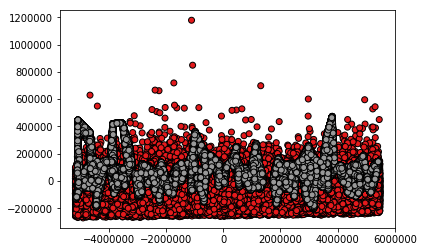

In [62]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights = 'distance')
test_classifier(x,y,clf,use_PCA=True)

In [44]:
clf = ExtraTreesClassifier(n_estimators=20, max_depth=None,min_samples_split=2, random_state=0, criterion='entropy')
test_classifier(x,y,clf,use_PCA=True)

TP: 20
FP: 4320
FN: 63
TN: 42937
Accuracy:0.9074144486692015
Recall:0.24096385542168675
Specificity:0.9085849715386081
Precision:0.004608294930875576


In [50]:
clf = AdaBoostClassifier(n_estimators=1000)
test_classifier(x,y,clf,use_PCA=False)

TP: 37
FP: 923
FN: 47
TN: 46333
Accuracy:0.9795099281791297
Recall:0.44047619047619047
Specificity:0.9804680887083121
Precision:0.03854166666666667
